In [ ]:
"""
C:\Users\Gourav.Kumar\Downloads\ds_projects\eda>
C:\Program Files\Python312\python.exe -m venv .venv
python -c "import urllib.request, json; print(json.loads(urllib.request.urlopen('https://www.howsmyssl.com/a/check').read())['tls_version'])"
python -m pip install --trusted-host pypi.python.org --trusted-host files.pythonhosted.org --trusted-host pypi.org --upgrade pip
python -m pip install --trusted-host pypi.python.org --trusted-host files.pythonhosted.org --trusted-host pypi.org ipykernel -U --force-reinstall                          
python.exe -m pip install ipykernel -U --force-reinstall
"""

In [2]:
import pandas as pd
import pymc as pm
import numpy as np
import matplotlib.pyplot as plt

WARNING (pytensor.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [4]:
file = "C:/Users/Gourav.Kumar/Downloads/data_jarvis/Mexico/Bouillon/KNORR/BouillonPolloComprimidos21/Input/MMXBOKNBouillonPolloComprimidos21MTTT_KNORRBouillonPolloComprimidos21/df_train.csv"
df_train = pd.read_csv(file)
df_train.head()

,Target,Avg_Temp.lag1,Price,TMI,TV_NACIONAL.lag1,WD
0,12.688011,3.269569,5.501140,-4.60517,-11.512925,4.488636
1,12.695438,3.269569,5.512777,-4.60517,-11.512925,4.488636
2,12.658332,3.284664,5.504326,-4.60517,-11.512925,4.488636
3,12.724450,3.280911,5.515804,-4.60517,14.694344,4.499810
4,12.707975,3.214868,5.510204,-4.60517,15.580315,4.488636


In [21]:
# Pull out X and Y of interest
# x_ftr= ['Price','WD']
x_ftr= 'Price'
y_ftr = 'Target'
xs = df_train[x_ftr] 
ys = df_train[y_ftr]
 
# Take log-transform 
# xs = np.log(xs)
# ys = np.log(ys)

In [22]:
slope_prior, intercept_prior = np.polyfit(xs.values.flatten(), ys.values.flatten(), 1)

In [23]:
### PyMC linear model
with pm.Model() as model:
     
    # Priors
    alpha = pm.Normal('alpha', mu=intercept_prior, sigma=10)
    beta = pm.Normal('beta', mu=slope_prior, sigma=10)
    sigma = pm.HalfNormal('sigma', sigma=1)
 
    # mean/expected value of the model
    mu = alpha + beta * xs
 
    # likelihood
    y = pm.Normal('y', mu=mu, sigma=sigma, observed=ys)
 
    # sample from the posterior
    trace = pm.sample(100)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma]


c:\Users\Gourav.Kumar\Downloads\ds_projects\eda\.venv\Lib\site-packages\rich\live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

In [14]:
## Generate posterior predictive samples
ppc = pm.sample_posterior_predictive(trace, model=model)

Sampling: [y]


c:\Users\Gourav.Kumar\Downloads\ds_projects\eda\.venv\Lib\site-packages\rich\live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

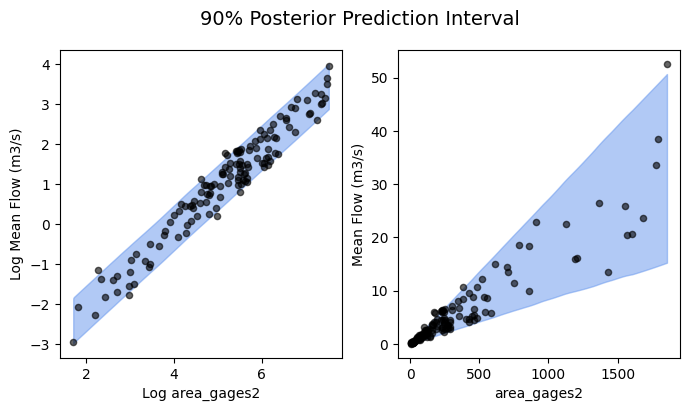

In [19]:
import arviz as az
### Plot the posterior predictive interval
fig, ax = plt.subplots(ncols=2, figsize=(8,4))
 
# log space
az.plot_hdi(xs, ppc['posterior_predictive']['y'], 
            color='cornflowerblue', ax=ax[0], hdi_prob=0.9)
ax[0].scatter(xs, ys, alpha=0.6, s=20, color='k')
ax[0].set_xlabel('Log ' + x_ftr)
ax[0].set_ylabel('Log Mean Flow (m3/s)')
 
# original dim space
az.plot_hdi(np.exp(xs), np.exp(ppc['posterior_predictive']['y']), 
            color='cornflowerblue', ax=ax[1], hdi_prob=0.9)
ax[1].scatter(np.exp(xs), np.exp(ys), alpha=0.6, s=20, color='k')
ax[1].set_xlabel(x_ftr)
ax[1].set_ylabel('Mean Flow (m3/s)')
plt.suptitle('90% Posterior Prediction Interval', fontsize=14)
plt.show()